In [48]:
# Imports
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat

import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing params
Check this paper for more details: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8648261/

In [63]:
# General
root_dir = "/mnt/c/Users/gcantisani/Documents/EEG_experiments/pygame-logitechG29_wheel/results/mb_Aaron/"
output_base = './outputs/EEG/pre&seg/'
csv_pre = 'preprocessing_pipeline.csv'
FPS_feat = 100 # Hz	
NR_TRIALS = 10

In [64]:
# Notch filtering
freq_notch = 60

# Bandpass filtering
bandpass = '1-30Hz'
freq_low   = 1
freq_high  = 30
ftype = 'butter'
order = 3

# Spherical interpolation
interpolation = 'spline'

# Rereferencing using average of mastoids electrodes
reref_type = 'Average'  

# Downsampling
downfreq = FPS_feat

## Load features

- .csv file containing the features to track

In [65]:
files = glob.glob(os.path.join(root_dir, '**', '*.csv'), recursive=True)

# Print the list of files
for idx, file in enumerate(files):
    print(idx, file.split('/')[-1])


file = files[0]
feat = pd.read_csv(file, skiprows=1)
print(feat.shape)
print(feat['time(s)'].values.shape)
print(feat['error'].values.shape)
print(feat['trail_pos'].values.shape)

0 mb_Aaron_trial_1.csv
1 mb_Aaron_trial_10.csv
2 mb_Aaron_trial_2.csv
3 mb_Aaron_trial_3.csv
4 mb_Aaron_trial_4.csv
5 mb_Aaron_trial_5.csv
6 mb_Aaron_trial_6.csv
7 mb_Aaron_trial_7.csv
8 mb_Aaron_trial_8.csv
9 mb_Aaron_trial_9.csv
(8775, 4)
(8775,)
(8775,)
(8775,)


## Load subjct-specific data
- .bdf file containing the EEG data

In [66]:
# Find BioSemi files in root_dir
extension = '*.vhdr'
files = glob.glob(os.path.join(root_dir, '**', extension), recursive=True)

# Print the list of files
for idx, file in enumerate(files):
    print(idx, file.split('/')[-1])

0 mb_Aaron.vhdr


In [67]:
# Select which file to open - to be changed with a foor loop and create corrisponding output folder
file_to_open = files[0]

# Create output folder
name_subject = file_to_open.split('/')[-1].split('.')[0]
output_dir = os.path.join(output_base, reref_type, name_subject)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Create file that keeps track of the preprocessing
df_pre = pd.DataFrame()

file_to_open

'/mnt/c/Users/gcantisani/Documents/EEG_experiments/pygame-logitechG29_wheel/results/mb_Aaron/mb_Aaron.vhdr'

In [68]:
if '.bdf' in file_to_open:
    raw = mne.io.read_raw_bdf(file_to_open, eog=None, misc=None, stim_channel='auto', 
                            infer_types=False, preload=False, verbose=None)
    N_start_events = mne.find_events(raw)
elif '.vhdr' in file_to_open:
    raw = mne.io.read_raw_brainvision(vhdr_fname=file_to_open, preload=False, verbose=None,
                                    eog = ['ExG 1', 'ExG 2'])
    N_start_events = mne.events_from_annotations(raw)
    
raw.load_data()

Extracting parameters from /mnt/c/Users/gcantisani/Documents/EEG_experiments/pygame-logitechG29_wheel/results/mb_Aaron/mb_Aaron.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Stimulus/0', 'Stimulus/32768']
Reading 0 ... 585764  =      0.000 ...  1171.528 secs...


<RawBrainVision | mb_Aaron.eeg, 37 x 585765 (1171.5 s), ~165.4 MB, data loaded>

[[  2648      0  24576]
 [  3053      0  16384]
 [  3070      0   8192]
 [ 32258      0  32768]
 [ 84169      0  32768]
 [136272      0  32768]
 [188091      0  32768]
 [239910      0  32768]
 [291880      0  32768]
 [343674      0  32768]
 [396010      0  32768]
 [448146      0  32768]
 [500165      0  32768]]
[[ 32258      0  32768]
 [ 84169      0  32768]
 [136272      0  32768]
 [188091      0  32768]
 [239910      0  32768]
 [291880      0  32768]
 [343674      0  32768]
 [396010      0  32768]
 [448146      0  32768]
 [500165      0  32768]]
10


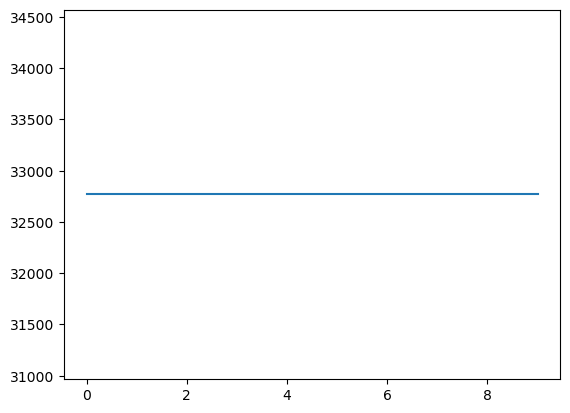

In [28]:
# Find starting sample of events in the trigger channel

# Select only relevant events
N_start_events = N_start_events[N_start_events[:, 2] == 32768]
# N_start_events = N_start_events[0][N_start_events[0][:, 2] == 10001]

# Get starting samples of events
N_start_events = N_start_events[:, 0]

# Get corresponding time
T_start_events = N_start_events / FPS_feat

# Check there are as many triggers as the listened stimuli
assert len(N_start_events) == NR_TRIALS

# Get event start in sample at the new sampling frequency 
N_start_events_down = np.round(T_start_events * downfreq).astype(int)

# eeg.plot(events=mne.find_events(raw), n_channels=len(raw.ch_names))

In [76]:
diff_samples = []
diff_times = []
for i in range(len(N_start_events) - 1):
    diff_samples.append(N_start_events[i+1] - N_start_events[i])
    diff_times.append(T_start_events[i+1] - T_start_events[i])


print(diff_samples)
print(diff_times)

data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

for ch_idx, ch_name in enumerate(raw.ch_names):
    plt.plot(data[ch_idx, :]/np.max(data[ch_idx, :]), label=ch_name)

TypeError: unsupported operand type(s) for -: 'dict' and 'int'

In [8]:
# Check the metadata
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('the (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
print()  # insert a blank line in the output

# some examples of raw.info:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

print(raw.info)
# raw.plot(start=100, duration=10)

the (cropped) sample data object has 580000 time samples and 37 channels.
The last time sample is at 1159.998 seconds.
The first few channel names are AF7, Fpz, F7.

bad channels: []
500.0 Hz
None 

<Info | 7 non-empty values
 bads: []
 ch_names: AF7, Fpz, F7, Fz, T7, FC6, Fp1, F4, C4, Oz, CP6, Cz, PO8, CP5, ...
 chs: 36 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2023-07-12 23:28:01 UTC
 nchan: 37
 projs: []
 sfreq: 500.0 Hz
>


Effective window size : 4.096 (s)


/tmp/ipykernel_823/3893942093.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0, fmax=125, average=False)


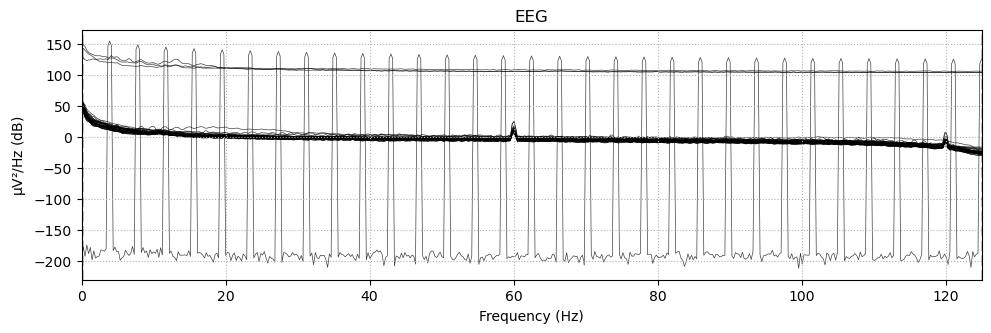

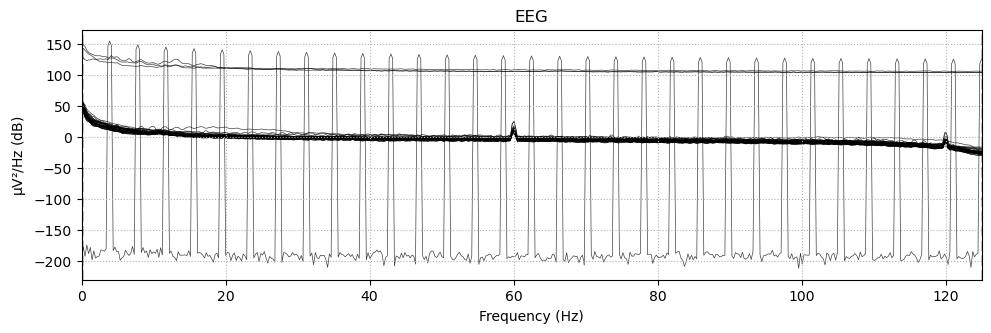

In [9]:
raw.plot_psd(fmin=0, fmax=125, average=False) 

In [10]:
for idx_ch, ch in enumerate(ch_names):
    print(idx_ch, ch)

0 AF7
1 Fpz
2 F7
3 Fz
4 T7
5 FC6
6 Fp1
7 F4
8 C4
9 Oz
10 CP6
11 Cz
12 PO8
13 CP5
14 O2
15 O1
16 P3
17 P4
18 P7
19 P8
20 Pz
21 PO7
22 T8
23 C3
24 Fp2
25 F3
26 F8
27 FC5
28 AF8
29 A2
30 ExG 1
31 ExG 2
32 ACC32
33 ACC33
34 ACC34
35 Packet Counter
36 TRIGGER


Creating RawArray with float64 data, n_channels=30, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


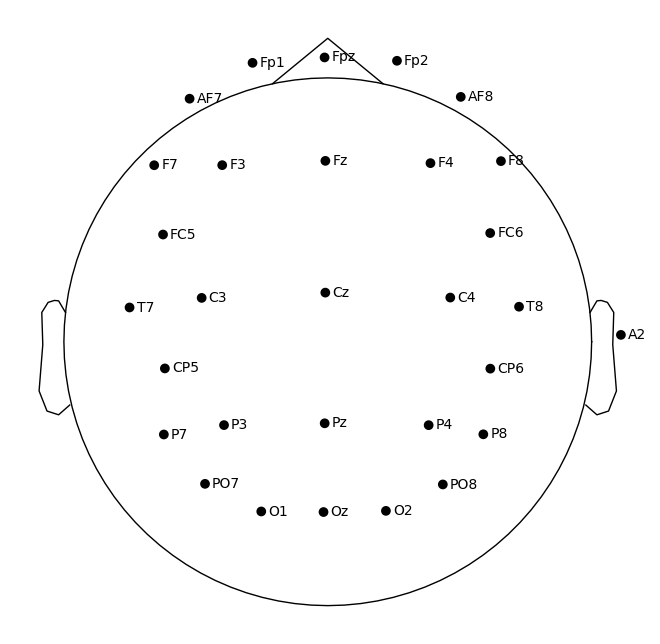

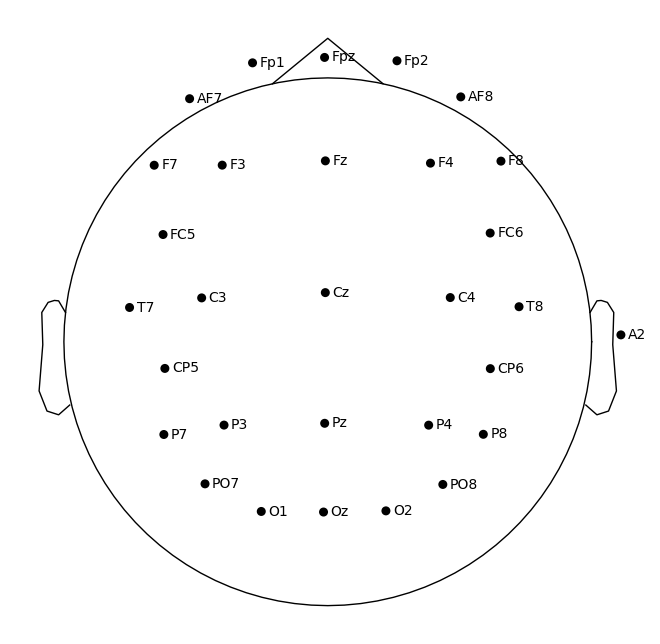

In [69]:
raw.info.set_montage('standard_1020', match_case=False)
mne.viz.plot_montage(raw.info.get_montage())

In [62]:
eeg_channels = ch_names[0:29]
eeg = raw.copy().pick_channels(eeg_channels)
eeg.plot(start=100, duration=5, n_channels=len(raw.ch_names))

Using qt as 2D backend.
Opening raw-browser...


Closing raw-browser...
Channels marked as bad:
none


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 sec)



/home/gcantisani/anaconda3/envs/eelbrain_feat_extr/lib/python3.10/site-packages/mne/filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/home/gcantisani/anaconda3/envs/eelbrain_feat_extr/lib/python3.10/site-packages/mne/filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Opening raw-browser...
Effective window size : 4.096 (s)


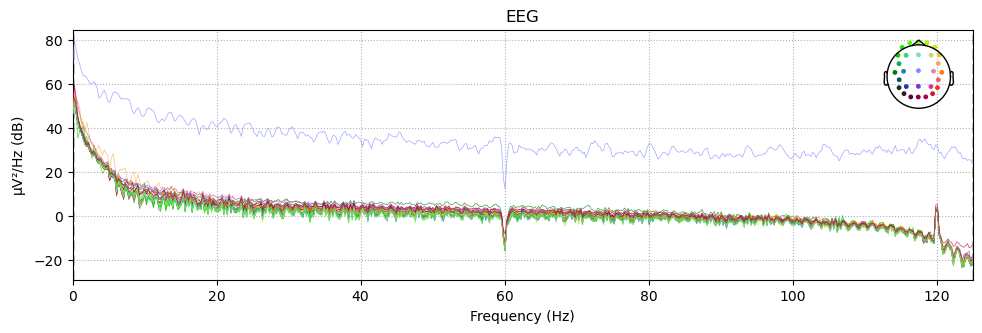

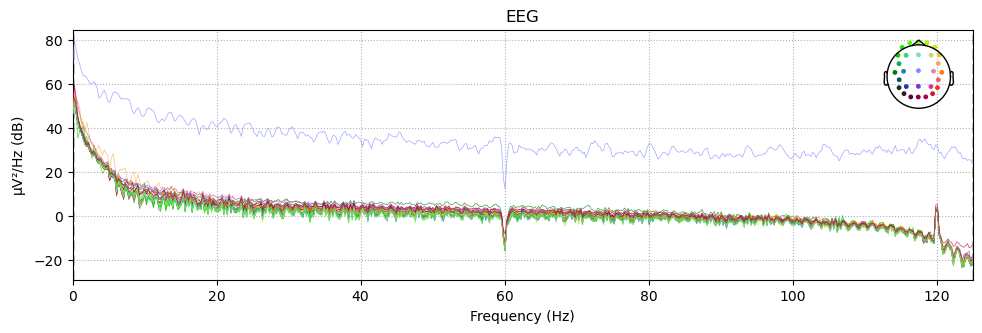

In [136]:
eeg = eeg.notch_filter(freqs=freq_notch)
df_pre['notch'] = [freq_notch]
eeg.plot(start=100, duration=10)
eeg.plot_psd(fmin=0, fmax=125, average=False) 

Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Opening raw-browser...
Effective window size : 4.096 (s)


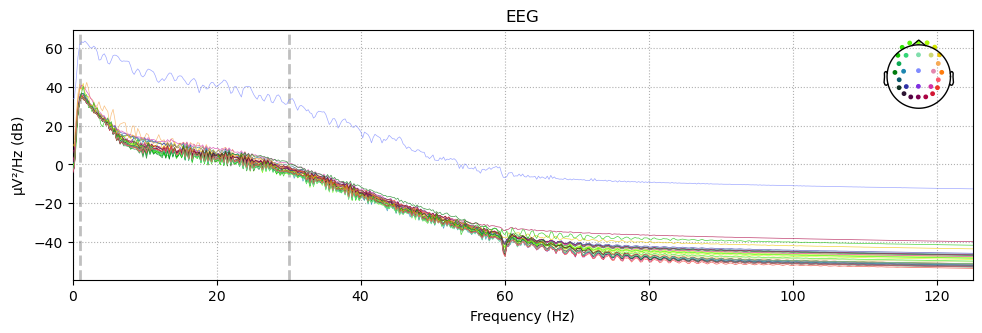

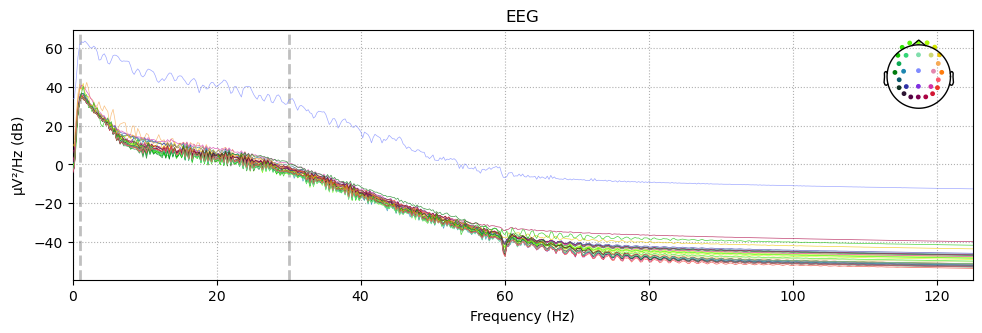

In [137]:
iir_params = dict(order=order, ftype=ftype)
filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'], 
                                         l_freq=freq_low, h_freq=freq_high, 
                                         method='iir', iir_params=iir_params)

eeg = eeg.filter(l_freq=freq_low, h_freq=freq_high, method='iir', iir_params=iir_params)
df_pre['Bandpass'] = [iir_params]
df_pre['HPF'] = [freq_low]
df_pre['LPF'] = [freq_high]
eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))
eeg.plot_psd(fmin=0, fmax=125, average=False) 

0 channels interpolated: []
Opening raw-browser...


/tmp/ipykernel_1375/2557666558.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  eeg = eeg.interpolate_bads(reset_bads=False)  #, method=interpolation


Effective window size : 4.096 (s)


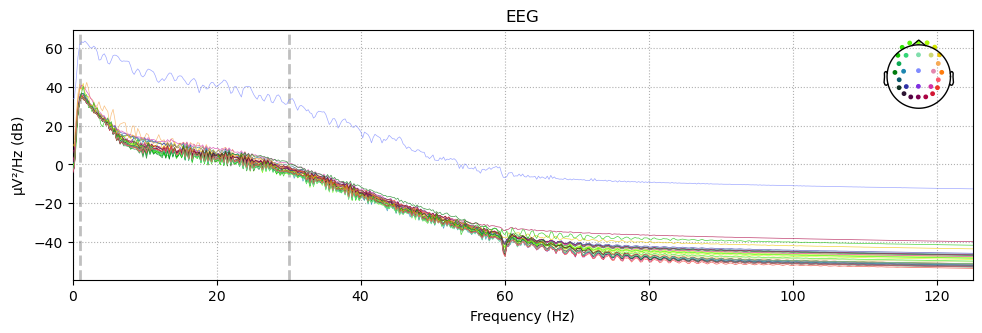

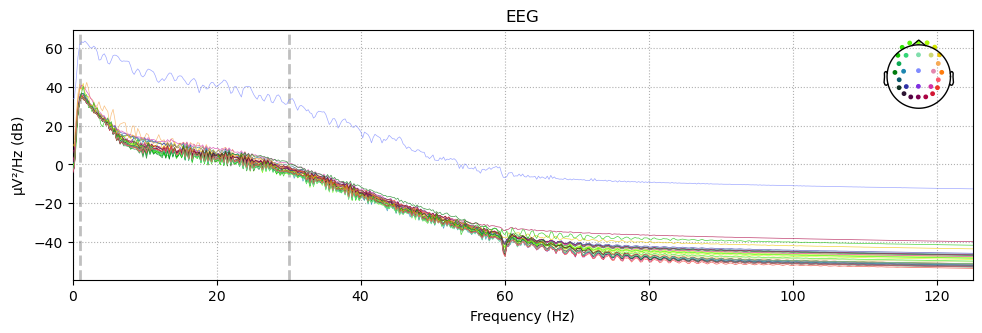

In [138]:
eeg = eeg.interpolate_bads(reset_bads=False)  #, method=interpolation

# Get the indices and names of the interpolated channels
interp_inds = eeg.info['bads']
interp_names = [eeg.info['ch_names'][i] for i in interp_inds]

# Print the number and names of the interpolated channels
print(f'{len(interp_inds)} channels interpolated: {interp_names}')

df_pre['interpolation'] = [interpolation]
df_pre['interp_inds'] = [interp_inds]
df_pre['interp_names'] = [interp_names]

eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))
eeg.plot_psd(fmin=0, fmax=125, average=False) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Opening raw-browser...
Effective window size : 4.096 (s)


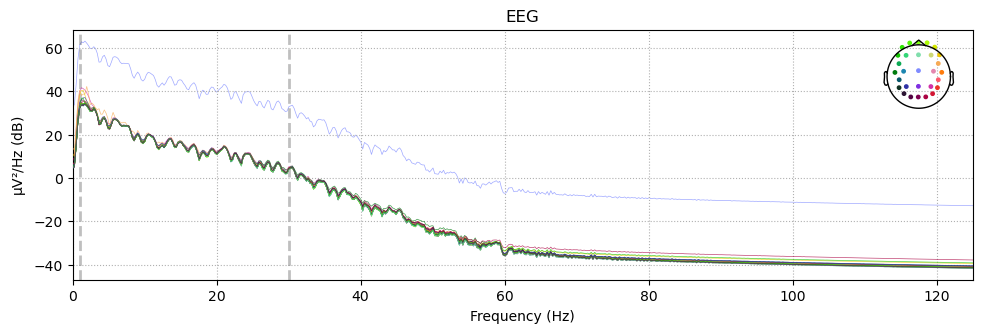

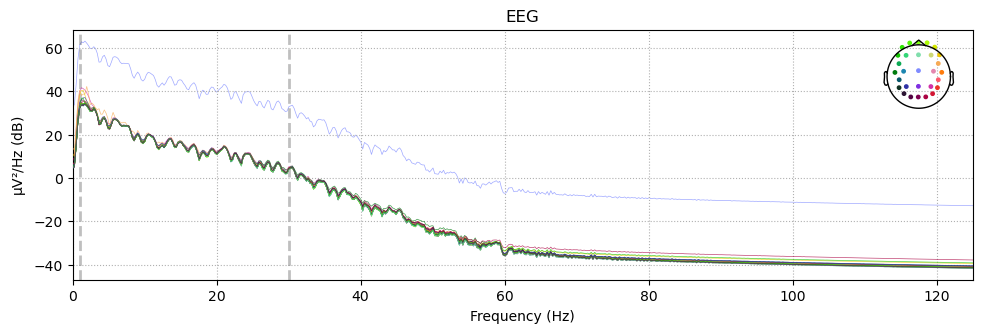

In [139]:
if reref_type == 'Mastoids':
    reref_channels = ['M1', 'M2']   
else:
    reref_channels = 'average'

eeg = eeg.set_eeg_reference(ref_channels=reref_channels)
df_pre['reref_type'] = [reref_type]
df_pre['reref_channels'] = [reref_channels]
eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))
eeg.plot_psd(fmin=0, fmax=125, average=False) 

<Info | 9 non-empty values
 bads: []
 ch_names: AF7, Fpz, F7, Fz, T7, FC6, Fp1, F4, C4, Oz, CP6, Cz, PO8, CP5, ...
 chs: 29 EEG
 custom_ref_applied: True
 dig: 32 items (3 Cardinal, 29 EEG)
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2023-07-07 18:16:49 UTC
 nchan: 29
 projs: []
 sfreq: 100.0 Hz
>
Opening raw-browser...
Effective window size : 20.480 (s)


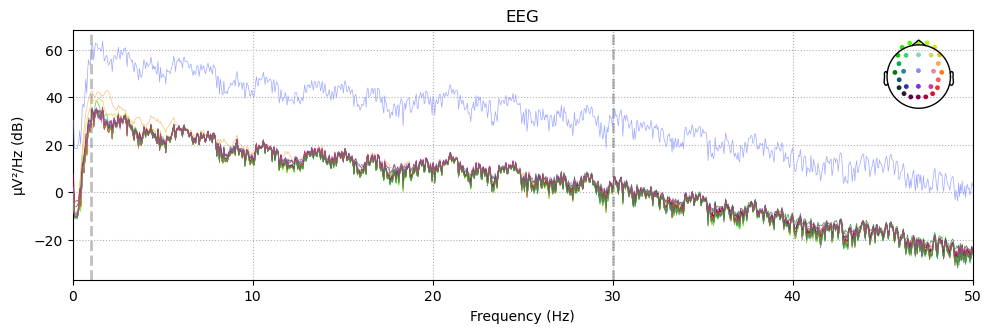

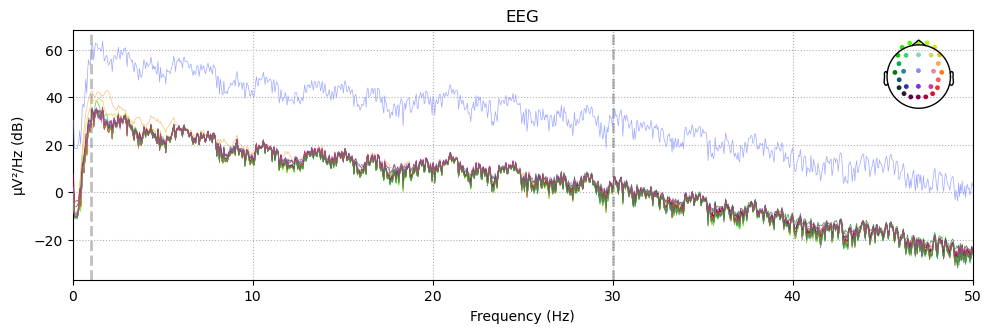

In [140]:
eeg = eeg.resample(sfreq=downfreq)
df_pre['downfreq'] = [downfreq]
print(eeg.info)
eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))
eeg.plot_psd(fmin=0, fmax=50, average=False) 

In [141]:
# Save preprocessing stages
df_pre.to_csv(os.path.join(output_dir, csv_pre), index=False)

## Segment EEG data in trials

In [14]:
# Find starting sample of events in the trigger channel
# print(N_start_events[0][:, 2] == 10001)
print(N_start_events)

# Select only relevant events
N_start_events = N_start_events[N_start_events[:, 2] == 32768]
# N_start_events = N_start_events[0][N_start_events[0][:, 2] == 10001]
# print(N_start_events)
print(N_start_events)

# Get starting samples of events
N_start_events = N_start_events[:, 0]
plt.plot(N_start_events)
print(len(N_start_events))

# Get corresponding time
T_start_events = N_start_events / FPS_feat

# Check there are as many triggers as the listened stimuli
# assert len(N_start_events) == NR_TRIALS

# Get event start in sample at the new sampling frequency 
N_start_events_down = np.round(T_start_events * downfreq).astype(int)

# eeg.plot(events=mne.find_events(raw), n_channels=len(raw.ch_names))

[ 22414  74258 126411 178280 230333 282510 334705 386849 439085 491429
 559917]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(37, 585765)
(585765,)


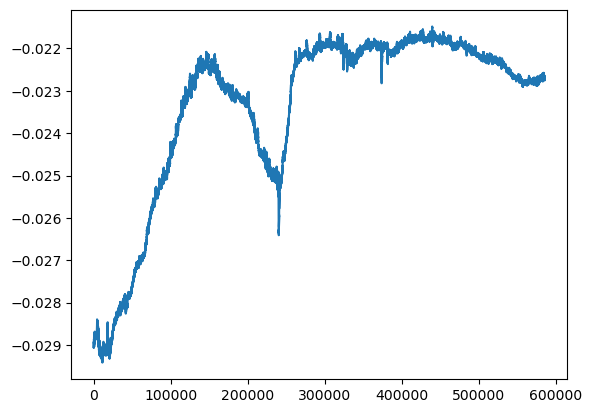

In [78]:
data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

plt.plot(data[5, :])

# for ch_idx, ch_name in enumerate(raw.ch_names):
#     plt.plot(data[ch_idx, :]/np.max(data[ch_idx, :]), label=ch_name)

In [79]:
diff_samples = []
diff_times = []
for i in range(len(N_start_events) - 1):
    diff_samples.append(N_start_events[i+1] - N_start_events[i])
    diff_times.append(T_start_events[i+1] - T_start_events[i])


print(diff_samples)
print(diff_times)

data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

for ch_idx, ch_name in enumerate(raw.ch_names):
    plt.plot(data[ch_idx, :]/np.max(data[ch_idx, :]), label=ch_name)

[46502, 52277, 52060, 52320, 52361, 52237, 52227, 52443, 52353, 52352, 62387, 1515]
[465.02, 522.77, 520.6, 523.1999999999998, 523.6100000000001, 522.3699999999999, 522.27, 524.4300000000003, 523.5299999999997, 523.5200000000004, 623.8699999999999, 15.149999999999636]


In [154]:
# Segment EEG 
FPS_feat = 100 # Hz	
NR_TRIALS = 10
duration_seconds = 120
filenames = []
for idx, onset_seconds in enumerate(T_start_events):
    print('Event onset in seconds: ', onset_seconds)
    
    # Crop the EEG data around the event onset, using the new sampling frequency
    eeg_cropped = eeg.copy().crop(tmin=onset_seconds, tmax=onset_seconds+duration_seconds).get_data()
    print('Cropped EEG data shape: ', eeg_cropped.shape)
    print()

    # Save file to mupy in the subject's folder
    print('Saving EEG responses to ', str(idx) , eeg_cropped.shape)
    savemat(os.path.join(output_dir, str(idx) + '.mat'), {'trial_data': eeg_cropped[0:29, :], 
                                                     'trial_mastoids': eeg_cropped[30:31, :]})

Event onset in seconds:  244.086
Cropped EEG data shape:  (29, 12001)

Saving EEG responses to  0 (29, 12001)
Event onset in seconds:  377.994
Cropped EEG data shape:  (29, 12001)

Saving EEG responses to  1 (29, 12001)
Event onset in seconds:  511.916
Cropped EEG data shape:  (29, 12001)

Saving EEG responses to  2 (29, 12001)
Event onset in seconds:  779.28
Cropped EEG data shape:  (29, 12001)

Saving EEG responses to  3 (29, 12001)
Event onset in seconds:  1314.242
Cropped EEG data shape:  (29, 12001)

Saving EEG responses to  4 (29, 12001)


## Additional code

In [ ]:
fig = mne.viz.plot_events(N_start_events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id={'Start trial': 65281})
fig.subplots_adjust(right=0.7)  # make room for legend

In [ ]:
# Create an Annotations object from the list of tuples
annotations = mne.Annotations(onset=onsets_seconds,
                              duration=durations_seconds,
                              description=filenames,
                              orig_time=raw.info['meas_date'])

# Add the annotations to the Raw object
raw.set_annotations(annotations)

In [ ]:
# Loop through the annotations and extract the data for each trial
for annotation in annotations:
    # Get the start and stop time of the annotation
    start_time = annotation.onset
    stop_time = start_time + annotation.duration
    
    # Use the crop method to extract the data for this trial - tmin and tmax must be given in seconds
    trial_data = eeg.copy().crop(tmin=start_time, tmax=stop_time).get_data()
    
    # Select only EEG channels (remove mastoids)
    trial_data = trial_data[0:64, :]
    
    # Save file to mupy in the subject's folder
    print('Saving EEG responses to ', filename, trial_data.shape)
    np.save(os.path.join(output_dir, filename + '.npy'), trial_data)

(37, 580000)
(580000,)


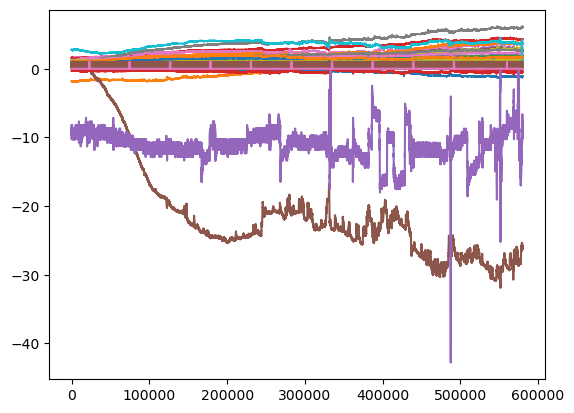

In [19]:
data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

for ch_idx, ch_name in enumerate(raw.ch_names):
    plt.plot(data[ch_idx, :]/np.max(data[ch_idx, :]), label=ch_name)

In [149]:
first_channel_data = raw.get_data(picks=[0, 64])
eeg_data = raw.get_data(picks=['eeg'])
eeg_data = eeg_data[0:29, :]
mastoids_data = raw.get_data(picks=['M1', 'M2'])

print(first_channel_data.shape)
print(eeg_data.shape)
print(mastoids_data.shape)

ValueError: All picks must be < n_channels (36), got [0, 64]